### Importação de Bibliotecas

###### Importa bibliotecas necessárias para manipulação de dados, processamento de textos e cálculo de similaridades

In [15]:
import os
import pandas as pd
import re
from PyPDF2 import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

### Extração do conteúdo dos PDFs

###### Extrai o conteúdo dos PDFs e armazena em um DataFrame pandas, o qual será exportado para um arquivo CSV

In [16]:
# Define os caminhos para os diretórios de dados brutos e processados
RAW_DIR = '../../../data/raw'
PROCESSED_DIR = '../../../data/processed'

In [17]:
# Verifica se o diretório de saída para os dados processados existe
# caso contrário, cria-o
if not os.path.exists(PROCESSED_DIR):
    os.makedirs(PROCESSED_DIR)

# Função para extrair texto de um PDF
def extract_text_from_pdf(pdf_path):
    # Inicializa o leitor de PDF e extrai o texto de cada página do documento
    reader = PdfReader(pdf_path)
    text = ''
    for page in reader.pages:
        text += page.extract_text()
    return text

# Função de limpeza básica do texto
def clean_text(text):
    # Remover múltiplos espaços em branco e quebras de linha
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Processa todos os arquivos PDF no diretório de dados brutos
data = []
for filename in os.listdir(RAW_DIR):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(RAW_DIR, filename)
        raw_text = extract_text_from_pdf(pdf_path)
        clean_data = clean_text(raw_text)
        data.append({
            'filename': filename,
            'text': clean_data
        })

# Converte os dados para um DataFrame
df = pd.DataFrame(data)

# Salva o DataFrame em um arquivo CSV no diretório processed
output_file = os.path.join(PROCESSED_DIR, 'processed_data.csv')
df.to_csv(output_file, index=False)

print(f'Dados processados foram salvos em: {output_file}')

Dados processados foram salvos em: ../../../data/processed\processed_data.csv


In [19]:
csv_file = os.path.join(PROCESSED_DIR, 'processed_data.csv')

# Conta o número de linhas no arquivo CSV
df = pd.read_csv(csv_file)
num_linhas_csv = len(df)

# Conta o número de arquivos PDF processados
num_docs = len([filename for filename in os.listdir(RAW_DIR) if filename.endswith('.pdf')])

print(f"Número de linhas no CSV: {num_linhas_csv}")

# Validação
if num_linhas_csv == num_docs:
    print("Validação bem-sucedida: o número de linhas no CSV é igual ao número de documentos processados.")
else:
    print(f"Erro de validação: o número de linhas no CSV ({num_linhas_csv}) "
          f"é diferente do número de documentos processados ({num_docs}).")


Número de linhas no CSV: 75
Validação bem-sucedida: o número de linhas no CSV é igual ao número de documentos processados.


### Associação de TAGs aos PDFs

###### Dada a dificuldade de se obter um dataset rotulado, foi necessário associar tags aos PDFs manualmente. Para isso, foi utilizado um algoritmo de similaridade de cosseno para encontrar os PDFs mais similares às TAGs disponibilizadas pela CVM.

In [20]:
# Lista das tags fornecidas pela CVM
cvm_tags = [
    'Administradores de Carteiras', 'Agencias de Classificação de Risco de Crédito', 
    'Agentes Fiduciários', 'Alerta', 'Analistas de Valores Mobiliários', 
    'Assessores de Investimento', 'Ato Declaratório', 'Atuação Irregular', 
    'Audiência Pública', 'Auditor Independente', 'BDR', 'Cadastro de Participantes Regulados', 
    'Clubes de Investimento', 'Companhia', 'Comunicado ao Mercado', 'Concurso/Prêmio', 
    'Consultores de Valores Mobiliários', 'Convênio', 'Coronavirus', 'Corretora', 
    'Crowdfunding', 'Decisão do Colegiado', 'Deliberação', 'Educação Financeira', 
    'Evento', 'Fundos de Investimento', 'Fundos de Investimento em Direitos Creditórios', 
    'Fundos de Investimento em Participações', 'Fundos de Investimento Imobiliários', 
    'Gestão Institucional', 'Indenização', 'Infraestrutura do Mercado', 
    'Insider Trading', 'Intermediários', 'Investidores Nao Residentes', 'Julgamento', 
    'Julgamento_Insider', 'Mercados Organizados', 'Normas Contábeis', 'Nota', 
    'Ofertas Publicas', 'Ofício Circular', 'Ouvidoria', 'Parecer de Orientação', 
    'Pesquisa', 'Planejamento Estratégico', 'PLD/FTP', 'Processo Eletrônico', 
    'Protocolo Digital', 'Publicação', 'Ritos CVM', 'Sandbox Regulatório', 
    'Securitizadoras', 'Sistema de governança e gestão da CVM', 'Suitability', 
    'Suspensão', 'Tecnologia da Informação', 'Termo_Compromisso_Insider', 'Termo de Compromisso'
]

df['processed_text'] = df['text']

# Vetorização do texto e das tags
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['processed_text'])
tags_vectorized = vectorizer.transform(cvm_tags)

# Similaridade de cosseno entre o texto e as tags
cosine_similarities = cosine_similarity(X, tags_vectorized)

# Definir um limiar para a associação de múltiplas tags
threshold = 0.05

# Associação das tags mais relevantes com base na similaridade
def get_relevant_tags(similarity_row, threshold):
     return [cvm_tags[i] for i in range(len(similarity_row)) if similarity_row[i] > threshold]

df['associated_tags'] = [get_relevant_tags(row, threshold) for row in cosine_similarities]

# Adicionar as tags associadas à coluna 'tags'
df['tags'] = df['associated_tags'].apply(lambda x: ', '.join(x))

# Remover colunas desnecessárias e salvar o CSV
df_final = df.drop(columns=['associated_tags', 'processed_text'])
df_final.to_csv(output_file, index=False)


### Visualização das TAGs associadas

###### Visualização das TAGs associadas aos PDFs, incluindo a listagem das TAGs associadas a cada PDF e um gráfico de barras com a distribuição das TAGs

In [22]:
# Mostrar as tags associadas para cada documento
for i, row in df.iterrows():
    print(f"Documento {row['filename']}:")
    print(f"Texto: {row['text'][:100]}...")  # Mostra os primeiros 100 caracteres do texto
    print(f"Tags associadas: {', '.join(row['associated_tags'])}\n")

Documento Deli885.pdf:
Texto: COMISSÃO DE VALORES MOBILIÁRIOS Rua Sete de Setembro, 111/2 -5º e 23-34º Andares, Centro, Rio de Jan...
Tags associadas: Administradores de Carteiras, Agencias de Classificação de Risco de Crédito, Analistas de Valores Mobiliários, Assessores de Investimento, Cadastro de Participantes Regulados, Clubes de Investimento, Companhia, Consultores de Valores Mobiliários, Deliberação, Fundos de Investimento, Fundos de Investimento em Direitos Creditórios, Fundos de Investimento em Participações, Fundos de Investimento Imobiliários, Parecer de Orientação, Securitizadoras, Sistema de governança e gestão da CVM, Termo de Compromisso

Documento Deli886.pdf:
Texto: COMISSÃO DE VALORES MOBILIÁRIOS Rua Sete de Setembro, 111/2 -5º e 23-34º Andares, Centro, Rio de Jan...
Tags associadas: Administradores de Carteiras, Agencias de Classificação de Risco de Crédito, Analistas de Valores Mobiliários, Assessores de Investimento, Cadastro de Participantes Regulados, Clubes de I

In [23]:
all_tags = [tag for tags in df['associated_tags'] for tag in tags]
tag_counts = pd.Series(all_tags).value_counts()

print("Contagem das tags associadas:")
print(tag_counts)

Contagem das tags associadas:
Administradores de Carteiras                      74
Analistas de Valores Mobiliários                  74
Agencias de Classificação de Risco de Crédito     74
Consultores de Valores Mobiliários                74
Sistema de governança e gestão da CVM             74
Fundos de Investimento                            74
Fundos de Investimento Imobiliários               74
Assessores de Investimento                        73
Fundos de Investimento em Direitos Creditórios    73
Fundos de Investimento em Participações           73
Clubes de Investimento                            68
Parecer de Orientação                             63
Cadastro de Participantes Regulados               60
Termo de Compromisso                              57
Ofício Circular                                   33
Ofertas Publicas                                  14
Deliberação                                        9
Infraestrutura do Mercado                          7
Companhia       

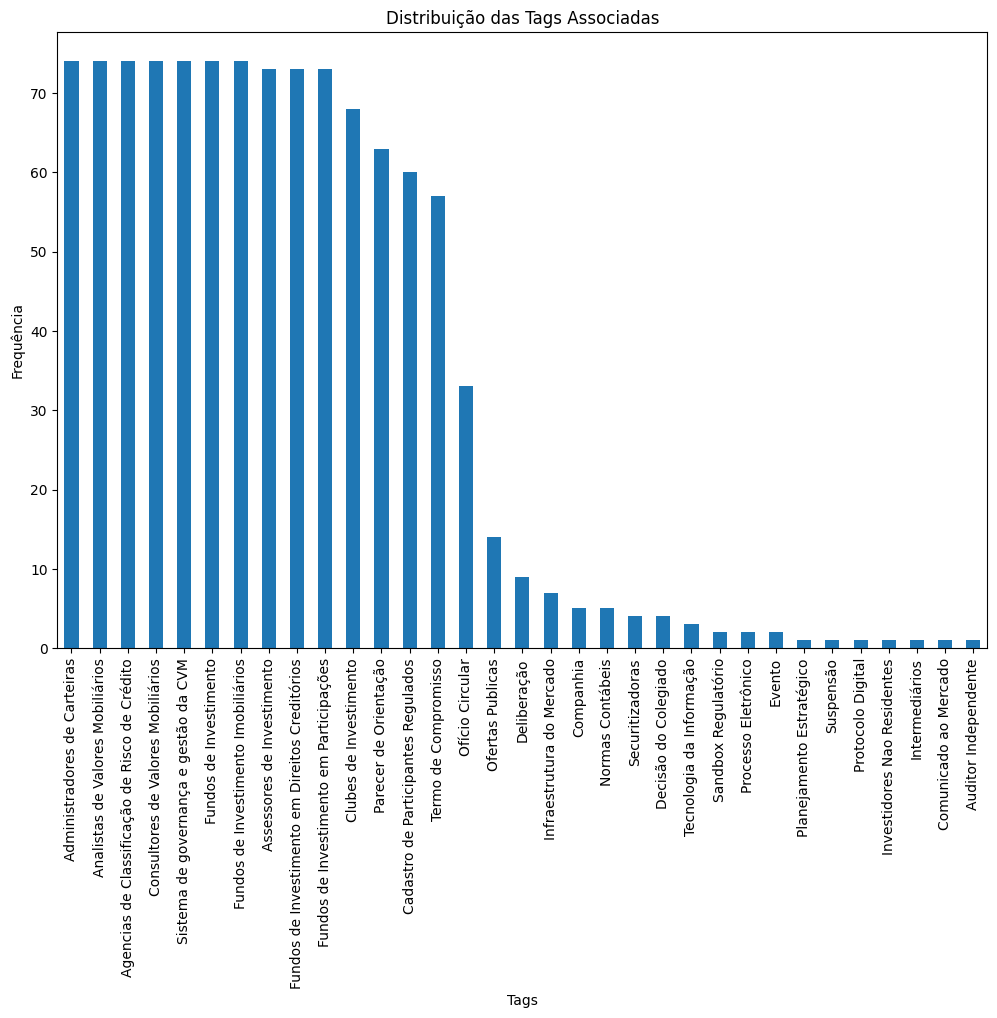

In [24]:
# Visualização da distribuição das tags
tag_counts = pd.Series(all_tags).value_counts()
plt.figure(figsize=(12, 8))
tag_counts.plot(kind='bar')
plt.title('Distribuição das Tags Associadas')
plt.xlabel('Tags')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.show()